In [1]:
import pandas as pd, numpy as np
from datetime import datetime
# import yfinance as yf
import tushare as ts
import time, urllib
ts.set_token('2f31c3932ead9fcc3830879132cc3ec8df3566550f711889d4a30f67')
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)

https://pypi.org/project/yfinance/

# Technical Indicators

# All Chinese Stocks

## 上证指数

In [22]:
# 网易爬数据

def get_page(url):  #获取页面数据
    req=urllib.request.Request(url,headers={
        'Connection': 'Keep-Alive',
        'Accept': 'text/html, application/xhtml+xml, */*',
        'Accept-Language':'zh-CN,zh;q=0.8',
        'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7.0; rv:11.0) like Gecko'
    })
    opener=urllib.request.urlopen(req)
    page=opener.read()
    return page

def get_index_history_byNetease(index_temp):
    """
    :param index_temp: for example, 'sh000001' 上证指数
    :return:
    """
    index_type=index_temp[0:2]
    index_id=index_temp[2:]
    if index_type=='sh':
        index_id='0'+index_id
    if index_type=="sz":
        index_id='1'+index_id
    url='http://quotes.money.163.com/service/chddata.html?code=%s&start=19900101&end=%s&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;VOTURNOVER;VATURNOVER'%(index_id,time.strftime("%Y%m%d"))

    page=get_page(url).decode('gb2312') #该段获取原始数据
    page=page.split('\r\n')
    col_info=page[0].split(',')   #各列的含义
    index_data=page[1:]     #真正的数据

    #为了与现有的数据库对应，这里我还修改了列名，大家不改也没关系
    col_info[col_info.index('日期')]='交易日期'   #该段更改列名称
    col_info[col_info.index('股票代码')]='指数代码'
    col_info[col_info.index('名称')]='指数名称'
    col_info[col_info.index('成交金额')]='成交额'

    index_data=[x.replace("'",'') for x in index_data]  #去掉指数编号前的“'”
    index_data=[x.split(',') for x in index_data]

    index_data=index_data[0:index_data.__len__()-1]   #最后一行为空，需要去掉
    pos1=col_info.index('涨跌幅')
    pos2=col_info.index('涨跌额')
    posclose=col_info.index('收盘价')
    index_data[index_data.__len__()-1][pos1]=0      #最下面行涨跌额和涨跌幅为None改为0
    index_data[index_data.__len__()-1][pos2]=0
    for i in range(0,index_data.__len__()-1):       #这两列中有些值莫名其妙为None 现在补全
        if index_data[i][pos2]=='None':
            index_data[i][pos2]=float(index_data[i][posclose])-float(index_data[i+1][posclose])
        if index_data[i][pos1]=='None':
            index_data[i][pos1]=(float(index_data[i][posclose])-float(index_data[i+1][posclose]))/float(index_data[i+1][posclose])

    # print(col_info)
    return [index_data,col_info]
# --------------------- 
# 版权声明：本文为CSDN博主「multiangle」的原创文章，遵循CC 4.0 by-sa版权协议，转载请附上原文出处链接及本声明。
# 原文链接：https://blog.csdn.net/u014595019/article/details/48445223

sh = get_index_history_byNetease("sh000001") 
df_ne = pd.DataFrame()
df_ne['columns_to_split'] = pd.DataFrame(sh).T[0]
col_list = list(pd.DataFrame(sh).T[1])[:12]
df_ne['columns_to_split'] = df_ne['columns_to_split'].apply(lambda x: str(x))
df_ne['columns_to_split'] = df_ne['columns_to_split'].apply(lambda x: x.replace("[", ""))
df_ne['columns_to_split'] = df_ne['columns_to_split'].apply(lambda x: x.replace("]", ""))

df_ne = df_ne['columns_to_split'].str.split(",", 12, expand = True)
df_ne.columns = col_list
df_ne.sort_values("交易日期", inplace = True)
df_ne.reset_index(inplace = True)
del df_ne['index']
df_ne.tail()

,交易日期,指数代码,指数名称,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,成交量,成交额
7066,'2019-11-14','000001','上证指数','2909.8697','2917.374','2899.6186','2907.7358','2905.2409','4.6288','0.1593','129145448','1.51576183392e+11'
7067,'2019-11-15','000001','上证指数','2891.3431','2917.8293','2891.2043','2911.35','2909.8697','-18.5266','-0.6367','135519463','1.52576392736e+11'
7068,'2019-11-18','000001','上证指数','2909.2002','2911.3784','2884.0883','2889.5495','2891.3431','17.8571','0.6176','124433177','1.44677413724e+11'
7069,'2019-11-19','000001','上证指数','2933.9908','2933.9908','2902.855','2904.2783','2909.2002','24.7906','0.8521','135417604','1.55770741258e+11'
7070,'2019-11-20','000001','上证指数','2911.0534','2930.4929','2907.4229','2928.1068','2933.9908','-22.9374','-0.7818','137357530','1.58543195636e+11'


In [24]:
df_ne = df_ne[['交易日期', '开盘价', '最高价', '最低价', '收盘价', '成交量']]
df_ne = df_ne.iloc[1:, :]
df_ne['交易日期'] = df_ne['交易日期'].apply(lambda x: x[1:-1])
df_ne['收盘价'] = df_ne['收盘价'].apply(lambda x: x[2:-1])
df_ne['收盘价'] = df_ne['收盘价'] = df_ne['收盘价'].apply(lambda x: float(x))
df_ne['最高价'] = df_ne['最高价'].apply(lambda x: x[2:-1])
df_ne['最高价'] = df_ne['最高价'] = df_ne['最高价'].apply(lambda x: float(x))
df_ne['最低价'] = df_ne['最低价'].apply(lambda x: x[2:-1])
df_ne['最低价'] = df_ne['最低价'] = df_ne['最低价'].apply(lambda x: float(x))
df_ne['开盘价'] = df_ne['开盘价'].apply(lambda x: x[2:-1])
df_ne['开盘价'] = df_ne['开盘价'] = df_ne['开盘价'].apply(lambda x: float(x))
# df_ne['前收盘'] = df_ne['前收盘'].apply(lambda x: x[2:-1])
# df_ne['前收盘'] = df_ne['前收盘'] = df_ne['前收盘'].apply(lambda x: float(x))
# df_ne['涨跌额'] = df_ne['涨跌额'].apply(lambda x: x[2:-1])
# df_ne['涨跌额'] = df_ne['涨跌额'] = df_ne['涨跌额'].apply(lambda x: float(x))
# df_ne['涨跌幅'] = df_ne['涨跌幅'].apply(lambda x: x[2:-1])
# df_ne['涨跌幅'] = df_ne['涨跌幅'] = df_ne['涨跌幅'].apply(lambda x: float(x))
df_ne['成交量'] = df_ne['成交量'].apply(lambda x: x[2:-1])
df_ne['成交量'] = df_ne['成交量'] = df_ne['成交量'].apply(lambda x: float(x))
# df_ne['成交额'] = df_ne['成交额'].apply(lambda x: x[2:-1])
# df_ne['成交额'] = df_ne['成交额'] = df_ne['成交额'].apply(lambda x: float(x))
df_ne.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

## 其他股票

In [2]:
today = str(datetime.now().date())

def get_data(code,start='20100101',end=today):
    df = ts.pro_bar(ts_code=code, adj='qfq', start_date=start, end_date=end)
    return df

#获取当前交易日最新的股票代码和简称
def get_code():
    codes = pro.stock_basic(list_status='L').ts_code.values
    return codes

#设置token
token='2f31c3932ead9fcc3830879132cc3ec8df3566550f711889d4a30f67'
pro = ts.pro_api(token)
codes = get_code()

In [3]:
len(codes)

3734

In [29]:
import eventlet
eventlet.monkey_patch()

ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"

ticker_list = codes[:4]
today = str(datetime.now().date())
start = '2010-01-01'
end = today
for ticker in ticker_list:
    if not os.path.exists(ch_db_path+ticker+".csv"):
        print("{} is new, start downloading now...".format(ticker))
        try:
            data = get_data(ticker)
            data['trade_date'] = data['trade_date'].astype(str)
            data['trade_date'] = data['trade_date'].apply(lambda x:x[:4]+"-"+x[4:6]+"-"+x[6:])
            data.sort_values("trade_date", inplace = True)
            data.to_csv(ch_db_path+ticker+".csv", index = False)
            print("{} data file created: {}".format(ticker, end))
        except Exception as e:
            print(e)
            
    else:
        print("Already have data csv for {}".format(ticker))
        hist_data = pd.read_csv(ch_db_path+ticker+".csv")   
        try:
            hist_data_last_date = hist_data['trade_date'].values[-1]        
            if today > hist_data_last_date:
                print("Needs to update, start updating new data for {} now...".format(ticker))
                update_start = hist_data_last_date
                update_end = today
                with eventlet.Timeout(60,False):
                    try:
                        new_data = get_data(ticker, update_start, update_end)
                        new_data['trade_date'] = new_data['trade_date'].astype(str)
                        new_data['trade_date'] = new_data['trade_date'].apply(lambda x:x[:4]+"-"+x[4:6]+"-"+x[6:])
                        new_data.to_csv(ch_db_path+ticker+".csv", mode='a', header=False, index = False)
                        updated_duplicated_df = pd.read_csv(ch_db_path+ticker+".csv")
                        updated_df = updated_duplicated_df.drop_duplicates("trade_date")
                        updated_df.sort_values("trade_date", inplace = True)
                        updated_df.to_csv(ch_db_path+ticker+".csv", index = False)
                        print("New data updated till today for {}!".format(ticker))
                    except Exception as e:
                        print(e)
    #             print("Timed Out: Update Failed!")
            else:
                print("There's no new data to update for {}.".format(ticker))
        except Exception as e:
            print(e)

#     print("Data Download/Update for {} is Finished.".format(ticker))
    print("===============================================")
    
print("【Updated Finished for today!】")

Already have data csv for 000001.SZ
Needs to update, start updating new data for 000001.SZ now...
New data updated till today for 000001.SZ!
Already have data csv for 000002.SZ
There's no new data to update for 000002.SZ.
Already have data csv for 000004.SZ
There's no new data to update for 000004.SZ.
Already have data csv for 000005.SZ
There's no new data to update for 000005.SZ.
【Updated Finished for today!】


/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
# us_db_path = "C:/Users/Administrator/Documents/GitHub/mac_win_since_20191006/research_mac_win/US_database/"

# ticker_list = sp500_list

# today = str(datetime.now().date())
# start = "1990-01-01"
# end = today
# for ticker in ticker_list:
#     # Initial downloading:
#     if not os.path.exists(us_db_path+ticker+".csv"):
#         print("{} is new, start downloading now...".format(ticker))
#         data = yf.download(ticker, start=start, end=end)
#         data.reset_index(inplace = True)
#         data['Ticker'] = ticker
#         data.to_csv(us_db_path+ticker+".csv", index = False)
#         print("{} data file created: {}".format(ticker, end))
#     # Check for updates:
#     else:
#         print("Already have data csv for {}".format(ticker))
#         hist_data = pd.read_csv(us_db_path+ticker+".csv", encoding = "ANSI")
#         hist_data_last_date = hist_data['Date'].values[-1]
#         if today > hist_data_last_date:
#             print("Needs to update, start updating new data for {} now...".format(ticker))
#             update_start = hist_data_last_date
#             update_end = today
#             new_data = yf.download(ticker, start=update_start, end=update_end)
#             new_data.reset_index(inplace = True)
#             new_data['Ticker'] = ticker
#             new_data.to_csv(us_db_path+ticker+".csv", mode='a', header=False, index = False)
#             updated_duplicated_df = pd.read_csv(us_db_path+ticker+".csv", encoding = "ANSI")
#             updated_df = updated_duplicated_df.drop_duplicates()
#             updated_df.to_csv(us_db_path+ticker+".csv", index = False)
#             print("New data updated till today for {}!".format(ticker))
#         else:
#             print("There's no new data to update for {}.".format(ticker))
#     print("Data Download/Update for {} is Finished.".format(ticker))
#     print("===============================================")

In [ ]:
# Updating Data
# ticker_list = ["AAPL","GOOGL"]
# today = str(datetime.now().date())
# for ticker in ticker_list:
#     hist_data = pd.read_csv(ticker+".csv", encoding = "ANSI")
#     hist_data_last_date = hist_data['Date'].values[-1]
#     if today > hist_data_last_date:
#         print("Updating new data...")
#         update_start = hist_data_last_date
#         update_end = today
#         new_data = yf.download(ticker, start=update_start, end=update_end)
#         new_data.reset_index(inplace = True)
#         new_data['Ticker'] = ticker
#         new_data.to_csv(ticker+".csv", mode='a', header=False, index = False)
#         updated_duplicated_df = pd.read_csv(ticker+".csv", encoding = "ANSI")
#         updated_df = updated_duplicated_df.drop_duplicates()
#         updated_df.to_csv(ticker+".csv", index = False)
#         print("New data updated till today for {}!".format(ticker))
#     else:
#         print("There's no new data to update for {}.".format(ticker))

In [2]:
def MACD(df, n_fast, n_slow, n_macd): # n_fast = 12, n_slow = 26
    """
    http://stockcharts.com/docs/doku.php?id=scans:indicators

    """
    """
    MACD, MACD Signal and MACD difference, rationale CHECKED, code CHECKED, updated
    # Conventional look-back window for calculating MACDsign is 9
    """
    EMAfast = df['close'].ewm(span = n_fast, min_periods = n_fast - 1).mean()
    EMAslow = df['close'].ewm(span = n_slow, min_periods = n_slow - 1).mean()
    MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = MACD.ewm(span = n_macd, min_periods = n_macd-1).mean().rename('MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df['MACD_Diff'] = MACD
    df['MACD_Diff_EMA'] = MACDsign
    df['MACD'] = MACDdiff
    df['MACD_signal'] = df['MACD'].apply(lambda x: "多头信号" if x>0 else ("空头信号" if x<0 else "空仓信号"))
#     return MACD, MACDsign, MACDdiff
    return df

In [3]:
import glob
import os

In [5]:
ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
csv_path = ch_db_path+"*.csv"
files = glob.glob(csv_path)

In [6]:
# for file in files[3:]:
#     print("Updating trade_date for: ", file)
#     df = pd.read_csv(file)
#     df['trade_date'] = df['trade_date'].astype(str)
#     df['trade_date'] = df['trade_date'].apply(lambda x:x[:4]+"-"+x[4:6]+"-"+x[6:])
#     df.to_csv(file, index = False)

In [27]:
# analysis_tickers = ['AAPL',"GOOG","TSLA"]
# analysis_tickers = sp500()

# Rank stocks based on volumes

In [8]:
code_list = []
for file in files:
    ticker = file.split("CH_database/")[1].split(".csv")[0]
    code_list.append(ticker)

ticker_df_list = []
for ticker in code_list:
    print("Reading: ", ticker)
    ticker_df = pd.read_csv(ch_db_path+ticker+".csv")
    ticker_df_list.append(ticker_df)

Reading:  000001.SZ
Reading:  000002.SZ
Reading:  000004.SZ
Reading:  000005.SZ
Reading:  000006.SZ
Reading:  000007.SZ
Reading:  000008.SZ
Reading:  000009.SZ
Reading:  000010.SZ
Reading:  000011.SZ
Reading:  000012.SZ
Reading:  000014.SZ
Reading:  000016.SZ
Reading:  000017.SZ
Reading:  000018.SZ
Reading:  000019.SZ
Reading:  000020.SZ
Reading:  000021.SZ
Reading:  000023.SZ
Reading:  000025.SZ
Reading:  000026.SZ
Reading:  000027.SZ
Reading:  000028.SZ
Reading:  000029.SZ
Reading:  000030.SZ
Reading:  000031.SZ
Reading:  000032.SZ
Reading:  000034.SZ
Reading:  000035.SZ
Reading:  000036.SZ
Reading:  000037.SZ
Reading:  000038.SZ
Reading:  000039.SZ
Reading:  000040.SZ
Reading:  000042.SZ
Reading:  000043.SZ
Reading:  000045.SZ
Reading:  000046.SZ
Reading:  000048.SZ
Reading:  000049.SZ
Reading:  000050.SZ
Reading:  000055.SZ
Reading:  000056.SZ
Reading:  000058.SZ
Reading:  000059.SZ
Reading:  000060.SZ
Reading:  000061.SZ
Reading:  000062.SZ
Reading:  000063.SZ
Reading:  000065.SZ


Reading:  000966.SZ
Reading:  000967.SZ
Reading:  000968.SZ
Reading:  000969.SZ
Reading:  000970.SZ
Reading:  000971.SZ
Reading:  000972.SZ
Reading:  000973.SZ
Reading:  000975.SZ
Reading:  000976.SZ
Reading:  000977.SZ
Reading:  000978.SZ
Reading:  000980.SZ
Reading:  000981.SZ
Reading:  000982.SZ
Reading:  000983.SZ
Reading:  000985.SZ
Reading:  000987.SZ
Reading:  000988.SZ
Reading:  000989.SZ
Reading:  000990.SZ
Reading:  000993.SZ
Reading:  000996.SZ
Reading:  000997.SZ
Reading:  000998.SZ
Reading:  000999.SZ
Reading:  001696.SZ
Reading:  001872.SZ
Reading:  001896.SZ
Reading:  001965.SZ
Reading:  001979.SZ
Reading:  002001.SZ
Reading:  002002.SZ
Reading:  002003.SZ
Reading:  002004.SZ
Reading:  002005.SZ
Reading:  002006.SZ
Reading:  002007.SZ
Reading:  002008.SZ
Reading:  002009.SZ
Reading:  002010.SZ
Reading:  002011.SZ
Reading:  002012.SZ
Reading:  002013.SZ
Reading:  002014.SZ
Reading:  002015.SZ
Reading:  002016.SZ
Reading:  002017.SZ
Reading:  002019.SZ
Reading:  002020.SZ


Reading:  002408.SZ
Reading:  002409.SZ
Reading:  002410.SZ
Reading:  002411.SZ
Reading:  002412.SZ
Reading:  002413.SZ
Reading:  002414.SZ
Reading:  002415.SZ
Reading:  002416.SZ
Reading:  002417.SZ
Reading:  002418.SZ
Reading:  002419.SZ
Reading:  002420.SZ
Reading:  002421.SZ
Reading:  002422.SZ
Reading:  002423.SZ
Reading:  002424.SZ
Reading:  002425.SZ
Reading:  002426.SZ
Reading:  002427.SZ
Reading:  002428.SZ
Reading:  002429.SZ
Reading:  002430.SZ
Reading:  002431.SZ
Reading:  002432.SZ
Reading:  002433.SZ
Reading:  002434.SZ
Reading:  002435.SZ
Reading:  002436.SZ
Reading:  002437.SZ
Reading:  002438.SZ
Reading:  002439.SZ
Reading:  002440.SZ
Reading:  002441.SZ
Reading:  002442.SZ
Reading:  002443.SZ
Reading:  002444.SZ
Reading:  002445.SZ
Reading:  002446.SZ
Reading:  002447.SZ
Reading:  002448.SZ
Reading:  002449.SZ
Reading:  002450.SZ
Reading:  002451.SZ
Reading:  002452.SZ
Reading:  002453.SZ
Reading:  002454.SZ
Reading:  002455.SZ
Reading:  002456.SZ
Reading:  002457.SZ


Reading:  002841.SZ
Reading:  002842.SZ
Reading:  002843.SZ
Reading:  002845.SZ
Reading:  002846.SZ
Reading:  002847.SZ
Reading:  002848.SZ
Reading:  002849.SZ
Reading:  002850.SZ
Reading:  002851.SZ
Reading:  002852.SZ
Reading:  002853.SZ
Reading:  002855.SZ
Reading:  002856.SZ
Reading:  002857.SZ
Reading:  002858.SZ
Reading:  002859.SZ
Reading:  002860.SZ
Reading:  002861.SZ
Reading:  002862.SZ
Reading:  002863.SZ
Reading:  002864.SZ
Reading:  002865.SZ
Reading:  002866.SZ
Reading:  002867.SZ
Reading:  002868.SZ
Reading:  002869.SZ
Reading:  002870.SZ
Reading:  002871.SZ
Reading:  002872.SZ
Reading:  002873.SZ
Reading:  002875.SZ
Reading:  002876.SZ
Reading:  002877.SZ
Reading:  002878.SZ
Reading:  002879.SZ
Reading:  002880.SZ
Reading:  002881.SZ
Reading:  002882.SZ
Reading:  002883.SZ
Reading:  002884.SZ
Reading:  002885.SZ
Reading:  002886.SZ
Reading:  002887.SZ
Reading:  002888.SZ
Reading:  002889.SZ
Reading:  002890.SZ
Reading:  002891.SZ
Reading:  002892.SZ
Reading:  002893.SZ


Reading:  300302.SZ
Reading:  300303.SZ
Reading:  300304.SZ
Reading:  300305.SZ
Reading:  300306.SZ
Reading:  300307.SZ
Reading:  300308.SZ
Reading:  300309.SZ
Reading:  300310.SZ
Reading:  300311.SZ
Reading:  300312.SZ
Reading:  300313.SZ
Reading:  300314.SZ
Reading:  300315.SZ
Reading:  300316.SZ
Reading:  300317.SZ
Reading:  300318.SZ
Reading:  300319.SZ
Reading:  300320.SZ
Reading:  300321.SZ
Reading:  300322.SZ
Reading:  300323.SZ
Reading:  300324.SZ
Reading:  300325.SZ
Reading:  300326.SZ
Reading:  300327.SZ
Reading:  300328.SZ
Reading:  300329.SZ
Reading:  300330.SZ
Reading:  300331.SZ
Reading:  300332.SZ
Reading:  300333.SZ
Reading:  300334.SZ
Reading:  300335.SZ
Reading:  300336.SZ
Reading:  300337.SZ
Reading:  300338.SZ
Reading:  300339.SZ
Reading:  300340.SZ
Reading:  300341.SZ
Reading:  300342.SZ
Reading:  300343.SZ
Reading:  300344.SZ
Reading:  300345.SZ
Reading:  300346.SZ
Reading:  300347.SZ
Reading:  300348.SZ
Reading:  300349.SZ
Reading:  300350.SZ
Reading:  300351.SZ


Reading:  300736.SZ
Reading:  300737.SZ
Reading:  300738.SZ
Reading:  300739.SZ
Reading:  300740.SZ
Reading:  300741.SZ
Reading:  300742.SZ
Reading:  300743.SZ
Reading:  300745.SZ
Reading:  300746.SZ
Reading:  300747.SZ
Reading:  300748.SZ
Reading:  300749.SZ
Reading:  300750.SZ
Reading:  300751.SZ
Reading:  300752.SZ
Reading:  300753.SZ
Reading:  300755.SZ
Reading:  300756.SZ
Reading:  300757.SZ
Reading:  300758.SZ
Reading:  300759.SZ
Reading:  300760.SZ
Reading:  300761.SZ
Reading:  300762.SZ
Reading:  300763.SZ
Reading:  300765.SZ
Reading:  300766.SZ
Reading:  300767.SZ
Reading:  300768.SZ
Reading:  300769.SZ
Reading:  300770.SZ
Reading:  300771.SZ
Reading:  300772.SZ
Reading:  300773.SZ
Reading:  300775.SZ
Reading:  300776.SZ
Reading:  300777.SZ
Reading:  300778.SZ
Reading:  300779.SZ
Reading:  300780.SZ
Reading:  300781.SZ
Reading:  300782.SZ
Reading:  300783.SZ
Reading:  300785.SZ
Reading:  300786.SZ
Reading:  300787.SZ
Reading:  300788.SZ
Reading:  300789.SZ
Reading:  300790.SZ


Reading:  600446.SH
Reading:  600448.SH
Reading:  600449.SH
Reading:  600452.SH
Reading:  600455.SH
Reading:  600456.SH
Reading:  600458.SH
Reading:  600459.SH
Reading:  600460.SH
Reading:  600461.SH
Reading:  600462.SH
Reading:  600463.SH
Reading:  600466.SH
Reading:  600467.SH
Reading:  600468.SH
Reading:  600469.SH
Reading:  600470.SH
Reading:  600475.SH
Reading:  600476.SH
Reading:  600477.SH
Reading:  600478.SH
Reading:  600479.SH
Reading:  600480.SH
Reading:  600481.SH
Reading:  600482.SH
Reading:  600483.SH
Reading:  600485.SH
Reading:  600486.SH
Reading:  600487.SH
Reading:  600488.SH
Reading:  600489.SH
Reading:  600490.SH
Reading:  600491.SH
Reading:  600493.SH
Reading:  600495.SH
Reading:  600496.SH
Reading:  600497.SH
Reading:  600498.SH
Reading:  600499.SH
Reading:  600500.SH
Reading:  600501.SH
Reading:  600502.SH
Reading:  600503.SH
Reading:  600505.SH
Reading:  600506.SH
Reading:  600507.SH
Reading:  600508.SH
Reading:  600509.SH
Reading:  600510.SH
Reading:  600511.SH


Reading:  600978.SH
Reading:  600979.SH
Reading:  600980.SH
Reading:  600981.SH
Reading:  600982.SH
Reading:  600983.SH
Reading:  600984.SH
Reading:  600985.SH
Reading:  600986.SH
Reading:  600987.SH
Reading:  600988.SH
Reading:  600989.SH
Reading:  600990.SH
Reading:  600992.SH
Reading:  600993.SH
Reading:  600995.SH
Reading:  600996.SH
Reading:  600997.SH
Reading:  600998.SH
Reading:  600999.SH
Reading:  601000.SH
Reading:  601001.SH
Reading:  601002.SH
Reading:  601003.SH
Reading:  601005.SH
Reading:  601006.SH
Reading:  601007.SH
Reading:  601008.SH
Reading:  601009.SH
Reading:  601010.SH
Reading:  601011.SH
Reading:  601012.SH
Reading:  601015.SH
Reading:  601016.SH
Reading:  601018.SH
Reading:  601019.SH
Reading:  601020.SH
Reading:  601021.SH
Reading:  601028.SH
Reading:  601038.SH
Reading:  601058.SH
Reading:  601066.SH
Reading:  601068.SH
Reading:  601069.SH
Reading:  601077.SH
Reading:  601086.SH
Reading:  601088.SH
Reading:  601098.SH
Reading:  601099.SH
Reading:  601100.SH


Reading:  603519.SH
Reading:  603520.SH
Reading:  603527.SH
Reading:  603528.SH
Reading:  603530.SH
Reading:  603533.SH
Reading:  603535.SH
Reading:  603536.SH
Reading:  603538.SH
Reading:  603555.SH
Reading:  603556.SH
Reading:  603557.SH
Reading:  603558.SH
Reading:  603559.SH
Reading:  603566.SH
Reading:  603567.SH
Reading:  603568.SH
Reading:  603569.SH
Reading:  603577.SH
Reading:  603578.SH
Reading:  603579.SH
Reading:  603580.SH
Reading:  603583.SH
Reading:  603585.SH
Reading:  603586.SH
Reading:  603587.SH
Reading:  603588.SH
Reading:  603589.SH
Reading:  603590.SH
Reading:  603595.SH
Reading:  603596.SH
Reading:  603598.SH
Reading:  603599.SH
Reading:  603600.SH
Reading:  603601.SH
Reading:  603602.SH
Reading:  603603.SH
Reading:  603605.SH
Reading:  603606.SH
Reading:  603607.SH
Reading:  603608.SH
Reading:  603609.SH
Reading:  603610.SH
Reading:  603611.SH
Reading:  603612.SH
Reading:  603613.SH
Reading:  603615.SH
Reading:  603616.SH
Reading:  603617.SH
Reading:  603618.SH


In [9]:
tickers = pd.concat(ticker_df_list)

In [10]:
tickers[tickers['ts_code']=="000001.SZ"]

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,2010-01-04,8.0647,8.0844,7.7884,7.7983,8.0154,-0.2171,-2.7085,241922.76,5.802495e+05
1,000001.SZ,2010-01-05,7.8114,7.8608,7.4825,7.6634,7.7983,-0.1349,-1.7299,556499.82,1.293477e+06
2,000001.SZ,2010-01-06,7.6470,7.6470,7.4727,7.5319,7.6634,-0.1315,-1.7159,412143.13,9.444537e+05
3,000001.SZ,2010-01-07,7.5319,7.5812,7.3674,7.4497,7.5319,-0.0822,-1.0914,355336.85,8.041663e+05
4,000001.SZ,2010-01-08,7.4003,7.4825,7.3510,7.4332,7.4497,-0.0165,-0.2215,288543.06,6.506674e+05
5,000001.SZ,2010-01-11,7.7292,7.7884,7.3280,7.4332,7.4332,0.0000,0.0000,442846.02,1.009986e+06
6,000001.SZ,2010-01-12,7.4233,7.4497,7.1701,7.3839,7.4332,-0.0493,-0.6632,591795.91,1.310069e+06
7,000001.SZ,2010-01-13,7.1931,7.2030,6.8412,6.8938,7.3839,-0.4901,-6.6374,935039.47,1.990493e+06
8,000001.SZ,2010-01-14,6.9070,6.9596,6.7754,6.8971,6.8938,0.0033,0.0479,521194.74,1.089329e+06
9,000001.SZ,2010-01-15,6.9135,7.1207,6.7918,7.0484,6.8971,0.1513,2.1937,539508.46,1.146375e+06


In [11]:
def vol_ewm(vol_series, window_span):
    vol_mean = vol_series.ewm(span = window_span).mean()
    return vol_mean

In [70]:
tickers_test = tickers[(tickers['ts_code']=="000001.SZ")|(tickers['ts_code']=="000002.SZ")]

In [71]:
tickers_test

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,20100104,8.0647,8.0844,7.7884,7.7983,8.0154,-0.2171,-2.7085,241922.76,5.802495e+05
1,000001.SZ,20100105,7.8114,7.8608,7.4825,7.6634,7.7983,-0.1349,-1.7299,556499.82,1.293477e+06
2,000001.SZ,20100106,7.6470,7.6470,7.4727,7.5319,7.6634,-0.1315,-1.7159,412143.13,9.444537e+05
3,000001.SZ,20100107,7.5319,7.5812,7.3674,7.4497,7.5319,-0.0822,-1.0914,355336.85,8.041663e+05
4,000001.SZ,20100108,7.4003,7.4825,7.3510,7.4332,7.4497,-0.0165,-0.2215,288543.06,6.506674e+05
5,000001.SZ,20100111,7.7292,7.7884,7.3280,7.4332,7.4332,0.0000,0.0000,442846.02,1.009986e+06
6,000001.SZ,20100112,7.4233,7.4497,7.1701,7.3839,7.4332,-0.0493,-0.6632,591795.91,1.310069e+06
7,000001.SZ,20100113,7.1931,7.2030,6.8412,6.8938,7.3839,-0.4901,-6.6374,935039.47,1.990493e+06
8,000001.SZ,20100114,6.9070,6.9596,6.7754,6.8971,6.8938,0.0033,0.0479,521194.74,1.089329e+06
9,000001.SZ,20100115,6.9135,7.1207,6.7918,7.0484,6.8971,0.1513,2.1937,539508.46,1.146375e+06


In [77]:
tickers_test['10_vol_ewm'] = tickers_test.groupby(['ts_code'])['vol'].apply(lambda x: vol_ewm(x, 10))

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


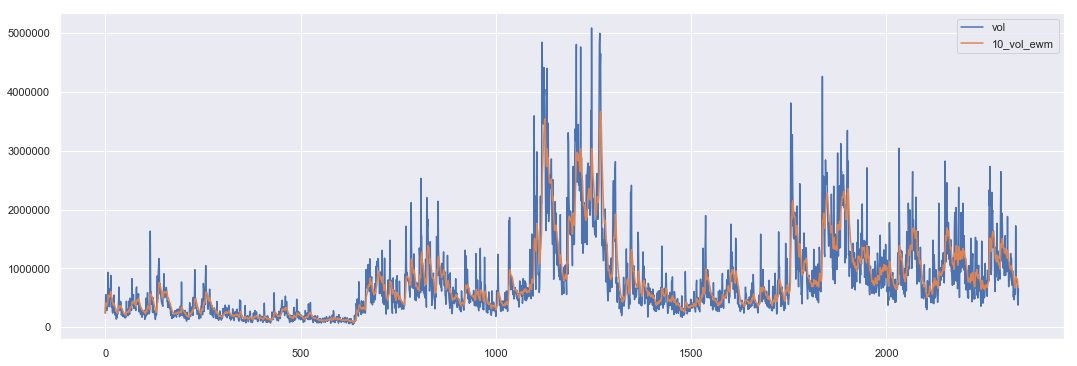

In [82]:
tickers_test[tickers_test['ts_code']=="000001.SZ"][['vol','10_vol_ewm']].plot(figsize = (18, 6))

In [53]:
signal_record = []
for ticker in code_list[:10]:
    print("Calculating Signal for: ", ticker)
    try:
        single_ticker_df = tickers[tickers['ts_code']==ticker]
        signal_df = MACD(single_ticker_df, 12, 26, 9)
        last_signal = signal_df[['ts_code','MACD_signal']].values[-1]
        signal_record.append(last_signal)
    except:
        pass

Calculating Signal for:  000001.SZ


/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Calculating Signal for:  000002.SZ
Calculating Signal for:  000004.SZ
Calculating Signal for:  000005.SZ
Calculating Signal for:  000006.SZ
Calculating Signal for:  000007.SZ
Calculating Signal for:  000008.SZ
Calculating Signal for:  000009.SZ
Calculating Signal for:  000010.SZ
Calculating Signal for:  000011.SZ


In [59]:
signal_record

[array(['000001.SZ', '空头信号'], dtype=object),
 array(['000002.SZ', '多头信号'], dtype=object),
 array(['000004.SZ', '多头信号'], dtype=object),
 array(['000005.SZ', '多头信号'], dtype=object),
 array(['000006.SZ', '多头信号'], dtype=object),
 array(['000007.SZ', '空头信号'], dtype=object),
 array(['000008.SZ', '多头信号'], dtype=object),
 array(['000009.SZ', '空头信号'], dtype=object),
 array(['000010.SZ', '空头信号'], dtype=object),
 array(['000011.SZ', '多头信号'], dtype=object)]

In [61]:
signal_record

[array(['000001.SZ', '空头信号'], dtype=object),
 array(['000002.SZ', '多头信号'], dtype=object),
 array(['000004.SZ', '多头信号'], dtype=object),
 array(['000005.SZ', '多头信号'], dtype=object),
 array(['000006.SZ', '多头信号'], dtype=object),
 array(['000007.SZ', '空头信号'], dtype=object),
 array(['000008.SZ', '多头信号'], dtype=object),
 array(['000009.SZ', '空头信号'], dtype=object),
 array(['000010.SZ', '空头信号'], dtype=object),
 array(['000011.SZ', '多头信号'], dtype=object)]